In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from importlib import reload

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

pd.options.display.max_columns = None

## Read data

In [2]:
df = pd.read_csv('data/result.csv', index_col=0)

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Subject,Final_G
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,1,6.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,1,5.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,1,8.0
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,1,15.0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,1,9.0


In [4]:
df.shape

(1044, 32)

## Categorical Feature Encoding
Label Encoding

In [5]:
encod_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 
                  'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 
                  'internet', 'romantic']

In [6]:
res_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures','famrel', 'freetime', 
                'goout', 'Dalc', 'Walc', 'health', 'absences', 'Subject', 'Final_G']

In [7]:
d = defaultdict(LabelEncoder)
label_transformed = df[encod_features].apply(lambda x: d[x.name].fit_transform(x))
df_trans = pd.concat([label_transformed, df[res_features]], axis=1)
df_trans.head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Subject,Final_G
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,4,0,1,1,0,0,0,1,1,0,0,4,4,2,2,0,4,3,4,1,1,3,6,1,6.0
1,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,1,0,1,1,1,2,0,5,3,3,1,1,3,4,1,5.0
2,0,0,1,1,1,0,2,2,1,1,0,1,0,1,1,1,0,1,1,1,2,3,4,3,2,2,3,3,10,1,8.0
3,0,0,1,0,1,1,3,1,1,0,1,1,1,1,1,1,1,4,2,1,3,0,3,2,2,1,1,5,2,1,15.0
4,0,0,1,0,1,2,2,1,0,0,1,1,0,1,1,0,0,3,3,1,2,0,4,3,2,1,2,5,4,1,9.0


In [8]:
### Split data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_trans.drop(labels=['Final_G'], axis=1),
    df_trans['Final_G'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((835, 30), (209, 30))

In [10]:
# Function fir Adjusted R-squared
# r-squared is dependent on the number of features. More independent variables in the model -> higher value of r2. 
# The adjusted R-squared increases when the new term improves the model more than would be expected by chance

In [11]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return 1 - (1 - r2) * coef

### Sequential Feature Selector

In [12]:
# step backward feature selection algorithm
sfs = SFS(RandomForestRegressor(n_estimators=50, 
                                n_jobs=2, 
                                random_state=0,
                                max_depth=4), 
           k_features=5, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=5)

sfs = sfs.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   31.4s finished

[2023-07-28 17:15:05] Features: 29/5 -- score: 0.27681295672203204[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   30.3s finished

[2023-07-28 17:15:35] Features: 28/5 -- score: 0.2810024804110144[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   29.4s finished

[2023-07-28 17:16:04] Features: 27/5 -- score: 0.28509841477736025[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

In [22]:
# support dic with column names
column_names_dic = {str(i): c for i, c in enumerate(X_train.columns)}

In [23]:
### Add adj r2
for i in sfs.subsets_:
    sfs.subsets_[i]['adjusted_avg_score'] = (
        adjust_r2(r2=sfs.subsets_[i]['avg_score'],
                  num_examples=X_train.shape[0]/5,
                  num_features=len(sfs.subsets_[i]['feature_idx']))
    )

In [25]:
# Add features names for remaining features and removed features
for i in sfs.subsets_:
    columns_in_ds = []
    columns_not_in_df = []
    idx_set = pd.DataFrame.from_dict(sfs.get_metric_dict()).T['feature_names'][i]
    diff_set = set(pd.DataFrame.from_dict(sfs.get_metric_dict()).T['feature_names'][30]) - set(idx_set)
    for col in idx_set:
        columns_in_ds.append(column_names_dic[col])
    for col in diff_set:
        columns_not_in_df.append(column_names_dic[col])
    sfs.subsets_[i]['feature_in_name'] = columns_in_ds
    sfs.subsets_[i]['feature_out_name'] = columns_not_in_df

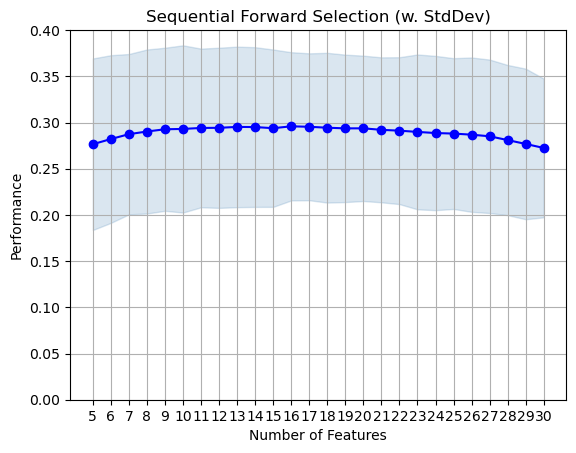

In [27]:
plt=reload(plt)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0, .4])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()

plt.show()

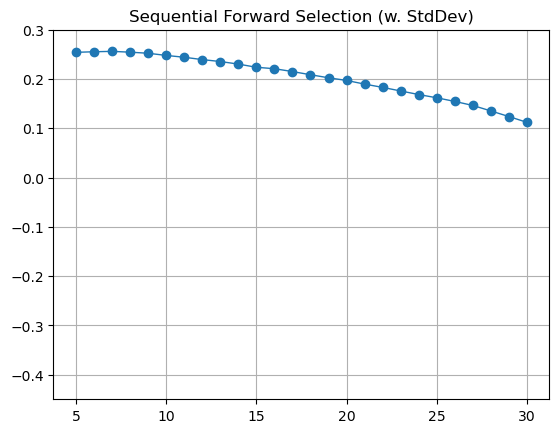

In [28]:
plt=reload(plt)
plt.plot(df_description.index[::-1], df_description.adjusted_avg_score[::-1], label = 'Face cream Sales Data', marker='o', linewidth=1)
plt.ylim([-0.45, .3])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel = 'Adjust r2'
plt.grid()

plt.show()

In [29]:
df_desc = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df_desc[:20]

,feature_idx,cv_scores,avg_score,feature_names,adjusted_avg_score,feature_in_name,feature_out_name,ci_bound,std_dev,std_err
30,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.2938464582512701, 0.30186209284629106, 0.38...",0.272463,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.111977,"[school, sex, address, famsize, Pstatus, Mjob,...",[],0.096461,0.07505,0.037525
29,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.3169789760885928, 0.2977909550028669, 0.397...",0.276813,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...",0.12373,"[school, sex, address, famsize, Pstatus, Mjob,...",[Fjob],0.104753,0.081502,0.040751
28,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.3165413387331706, 0.3084694170246636, 0.400...",0.281002,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...",0.135119,"[school, sex, address, famsize, Pstatus, Mjob,...","[Fjob, Fedu]",0.104439,0.081257,0.040628
27,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.33176730899319007, 0.31144654007722705, 0.4...",0.285098,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...",0.146233,"[school, sex, address, famsize, Pstatus, Mjob,...","[Fjob, internet, Fedu]",0.106715,0.083028,0.041514
26,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16...","[0.33024175261835487, 0.3142447356264493, 0.40...",0.286845,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16...",0.154402,"[school, sex, address, famsize, Pstatus, Mjob,...","[Fjob, internet, Fedu, paid]",0.107361,0.08353,0.041765
25,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 1...","[0.3300974465838111, 0.3130686026971905, 0.405...",0.288036,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 1...",0.161801,"[school, address, famsize, Pstatus, Mjob, reas...","[Fedu, paid, sex, Fjob, internet]",0.104856,0.081581,0.040791
24,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 1...","[0.33759790860250394, 0.3122951900265788, 0.40...",0.288624,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 1...",0.168392,"[school, address, famsize, Pstatus, Mjob, reas...","[Fedu, paid, sex, Fjob, internet, health]",0.107306,0.083487,0.041744
23,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 14, 16, 17, 1...","[0.33960760563297654, 0.3143918761473151, 0.40...",0.289836,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 14, 16, 17, 1...",0.175614,"[school, address, famsize, Pstatus, Mjob, reas...","[Fedu, activities, paid, sex, Fjob, internet, ...",0.107703,0.083797,0.041898
22,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 14, 16, 17, 1...","[0.3367119219165948, 0.3136113138669233, 0.403...",0.291192,"(0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 14, 16, 17, 1...",0.182902,"[school, address, famsize, Pstatus, Mjob, reas...","[Fedu, activities, paid, sex, Fjob, Walc, inte...",0.102155,0.07948,0.03974
21,"(0, 2, 3, 4, 7, 8, 9, 10, 13, 14, 16, 17, 19, ...","[0.3359900385477598, 0.31771628532746066, 0.40...",0.292087,"(0, 2, 3, 4, 7, 8, 9, 10, 13, 14, 16, 17, 19, ...",0.189561,"[school, address, famsize, Pstatus, reason, gu...","[Fedu, activities, paid, sex, Mjob, Fjob, Walc...",0.10082,0.078441,0.039221


In [30]:
df_desc.to_csv('data/SFS_results.csv')

## Filtering based on Adj R2 value 

In [33]:
# Hightest Adj R2
df_description[df_description.adjusted_avg_score == df_description.adjusted_avg_score.max()]

,feature_idx,cv_scores,avg_score,feature_names,adjusted_avg_score,feature_in_name,feature_out_name,ci_bound,std_dev,std_err
7,"(0, 9, 14, 20, 21, 28, 29)","[0.3649689714966877, 0.3133998830074801, 0.387...",0.287379,"(0, 9, 14, 20, 21, 28, 29)",0.256006,"[school, schoolsup, higher, studytime, failure...","[Dalc, sex, nursery, Medu, reason, Pstatus, fa...",0.11152,0.086767,0.043383


In [34]:
# Features subset
best_adj_r2_subset = list(df_description[df_description.adjusted_avg_score == df_description.adjusted_avg_score.max()]['feature_in_name'])[0]

In [35]:
print(len(best_adj_r2_subset))
best_adj_r2_subset

7


['school',
 'schoolsup',
 'higher',
 'studytime',
 'failures',
 'absences',
 'Subject']

## Filtering based on R2 value

In [36]:
# Hightest R2
df_description[df_description.avg_score == df_description.avg_score.max()]

,feature_idx,cv_scores,avg_score,feature_names,adjusted_avg_score,feature_in_name,feature_out_name,ci_bound,std_dev,std_err
16,"(0, 2, 7, 8, 9, 10, 14, 17, 19, 20, 21, 22, 23...","[0.34201776458119215, 0.31879672567304485, 0.4...",0.295897,"(0, 2, 7, 8, 9, 10, 14, 17, 19, 20, 21, 22, 23...",0.220793,"[school, address, reason, guardian, schoolsup,...","[Pstatus, famsize, Fedu, activities, nursery, ...",0.103078,0.080199,0.040099


In [37]:
best_r2_subset = list(df_description[df_description.avg_score == df_description.avg_score.max()]['feature_in_name'])[0]

In [38]:
print(len(best_r2_subset))
best_r2_subset

16


['school',
 'address',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'higher',
 'Medu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'Dalc',
 'absences',
 'Subject']

### Only  'sex' feature

In [66]:
rfr = RandomForestRegressor(n_estimators=100, 
                      n_jobs=2, 
                      random_state=10,
                      max_depth=6)

In [73]:
# All ds
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mean_squared_error(y_test, y_pred):.5f}')
print(f'R2: {r2:.5f}')
#display adjusted R-squared
adj_r2 = adjust_r2(r2, len(y_test), X_test.shape[1])
print(f'Adj R2: {adj_r2:.5f}')

MSE: 5.88893
R2: 0.28153
Adj R2: 0.16044


In [74]:
rfr.fit(X_train.drop('sex', axis=1), y_train)
y_pred = rfr.predict(X_test.drop('sex', axis=1))
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mean_squared_error(y_test, y_pred):.5f}')
print(f'R2: {r2:.5f}')
#display adjusted R-squared
adj_r2 = adjust_r2(r2, len(y_test), X_test.shape[1])
print(f'Adj R2: {adj_r2:.5f}')

MSE: 5.93524
R2: 0.27588
Adj R2: 0.15384
